In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Hyperparameters
batch_size = 128  # Increased batch size for faster training
lr = 0.0002
beta1 = 0.5
nz = 100  # noise vector size
nc = 3    # number of channels
ngf = 64  # generator feature maps
ndf = 64  # discriminator feature maps
num_epochs = 100
image_size = 64
max_dataset_size = 20000 

In [4]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, attr_file, transform=None, max_size=None):
        self.img_dir = img_dir
        self.transform = transform
        
        # Load attributes
        self.attr_df = pd.read_csv(attr_file)
        # Convert -1 to 0 for binary classification
        self.attr_df = self.attr_df.replace(-1, 0)
        
        # Limit dataset size for faster training
        if max_size and len(self.attr_df) > max_size:
            self.attr_df = self.attr_df.head(max_size)
            print(f"Limited dataset to {max_size} images for faster training")
        
    def __len__(self):
        return len(self.attr_df)
    
    def __getitem__(self, idx):
        img_name = self.attr_df.iloc[idx, 0]  # First column is image name
        img_path = os.path.join(self.img_dir, img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # If image fails to load, return a random tensor and label
            image = Image.fromarray(np.random.randint(0, 255, (64, 64, 3), dtype=np.uint8))
        
        if self.transform:
            image = self.transform(image)
        
        # Get brown hair attribute (assuming it's in the dataframe)
        brown_hair = self.attr_df.iloc[idx]['Brown_Hair']
        
        return image, torch.tensor(brown_hair, dtype=torch.float32)


In [5]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [6]:
# Generator
class Generator(nn.Module):
    def __init__(self, nz, nc, ngf, num_classes=1):
        super(Generator, self).__init__()
        self.nz = nz
        self.num_classes = num_classes
        
        # Embedding for condition - smaller embedding size
        self.label_emb = nn.Embedding(2, 10)  # 2 classes: brown hair or not, 10-dim embedding
        
        self.main = nn.Sequential(
            # Input: (nz + 10) x 1 x 1 = 110 channels
            nn.ConvTranspose2d(nz + 10, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: (nc) x 64 x 64
        )
    
    def forward(self, noise, labels):
        # Convert labels to int for embedding
        labels = labels.long()
        label_embedding = self.label_emb(labels)  # Shape: [batch_size, 10]
        
        # Reshape noise from [batch_size, nz, 1, 1] to [batch_size, nz]
        noise_flat = noise.squeeze(-1).squeeze(-1)  # Shape: [batch_size, nz]
        
        # Concatenate noise and label embedding
        gen_input = torch.cat([noise_flat, label_embedding], dim=1)  # Shape: [batch_size, nz + 10]
        
        # Reshape back to [batch_size, nz + 10, 1, 1] for ConvTranspose2d
        gen_input = gen_input.unsqueeze(-1).unsqueeze(-1)
        
        return self.main(gen_input)

In [7]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc, ndf, num_classes=1):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes
        
        # Embedding for condition - smaller embedding
        self.label_emb = nn.Embedding(2, image_size * image_size)
        
        self.main = nn.Sequential(
            # Input: (nc + 1) x 64 x 64 (1 channel for label)
            nn.Conv2d(nc + 1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, images, labels):
        # Convert labels to int for embedding
        labels = labels.long()
        label_embedding = self.label_emb(labels)  # Shape: [batch_size, image_size * image_size]
        label_embedding = label_embedding.view(labels.size(0), 1, image_size, image_size)
        
        # Concatenate image and label
        disc_input = torch.cat([images, label_embedding], dim=1)
        
        return self.main(disc_input).view(-1, 1).squeeze(1)


In [8]:
# Initialize networks
netG = Generator(nz, nc, ngf).to(device)
netD = Discriminator(nc, ndf).to(device)

In [9]:

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (label_emb): Embedding(2, 4096)
  (main): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  

In [11]:
# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
# Function to show generated images
def show_generated_images(generator, epoch, device, nz=100):
    generator.eval()
    with torch.no_grad():
        # Generate 10 images with brown hair (label = 1)
        noise = torch.randn(10, nz, 1, 1, device=device)
        labels = torch.ones(10, device=device)  # All brown hair
        fake_images = generator(noise, labels)
        
        # Debug: Check if images are in correct range
        print(f"Generated image range: [{fake_images.min().item():.3f}, {fake_images.max().item():.3f}]")
        
        # Denormalize images from [-1, 1] to [0, 1]
        fake_images = (fake_images + 1) / 2
        fake_images = torch.clamp(fake_images, 0, 1)  # Ensure valid range
        
        # Create subplot
        fig, axes = plt.subplots(2, 5, figsize=(15, 8))
        fig.suptitle(f'Generated Brown Hair Faces - Epoch {epoch}', fontsize=16)
        
        for i in range(10):
            row = i // 5
            col = i % 5
            img = fake_images[i].cpu().permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            axes[row, col].imshow(img)
            axes[row, col].axis('off')
            axes[row, col].set_title(f'Image {i+1}', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # Also generate some non-brown hair for comparison
        print("Generating non-brown hair faces for comparison:")
        labels_no_brown = torch.zeros(5, device=device)  # No brown hair
        noise_no_brown = torch.randn(5, nz, 1, 1, device=device)
        fake_images_no_brown = generator(noise_no_brown, labels_no_brown)
        fake_images_no_brown = (fake_images_no_brown + 1) / 2
        fake_images_no_brown = torch.clamp(fake_images_no_brown, 0, 1)
        
        fig2, axes2 = plt.subplots(1, 5, figsize=(15, 3))
        fig2.suptitle(f'Generated Non-Brown Hair Faces - Epoch {epoch}', fontsize=14)
        
        for i in range(5):
            img = fake_images_no_brown[i].cpu().permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            axes2[i].imshow(img)
            axes2[i].axis('off')
            axes2[i].set_title(f'No Brown Hair {i+1}', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    generator.train()

In [13]:
# Training function
def train_cgan():
    # IMPORTANT: Update these paths with your actual CelebA dataset paths
    img_dir = r"D:\sangita-mam\assginment-13\img_align_celeba\img_align_celeba"  # Path to CelebA images folder
    attr_file = r"D:\sangita-mam\assginment-13\list_attr_celeba.csv"  # Path to attributes CSV file
    
    # Check if paths exist and switch between real and mock dataset
    import os
    if os.path.exists(img_dir) and os.path.exists(attr_file):
        print("Using real CelebA dataset...")
        dataset = CelebADataset(img_dir, attr_file, transform=transform, max_size=max_dataset_size)
        print(f"Dataset size: {len(dataset)} images")
    else:
        print("CelebA dataset paths not found. Using mock dataset for demonstration...")
        print("Please update img_dir and attr_file paths above to use real CelebA data")
        
        # Mock dataset creation with more realistic face-like patterns
        class MockCelebADataset(Dataset):
            def __init__(self, size=max_dataset_size):
                self.size = size
                print("Creating mock face-like dataset for demonstration...")
                
            def __len__(self):
                return self.size
                
            def __getitem__(self, idx):
                # Create more structured "face-like" patterns instead of pure noise
                # This simulates basic face structure to help the GAN learn
                image = torch.zeros(3, image_size, image_size)
                
                # Add some structure: circular face shape, eye positions, etc.
                center = image_size // 2
                
                # Face oval
                y, x = torch.meshgrid(torch.arange(image_size), torch.arange(image_size), indexing='ij')
                face_mask = ((x - center) ** 2 / (center * 0.8) ** 2 + 
                           (y - center) ** 2 / (center * 1.0) ** 2) < 1
                
                # Skin tone (random but realistic)
                skin_color = torch.rand(3) * 0.3 + 0.4  # Range [0.4, 0.7]
                for c in range(3):
                    image[c][face_mask] = skin_color[c]
                
                # Add some random hair-like texture on top
                hair_region = y < center * 0.7
                hair_color = torch.rand(3) * 0.5  # Darker for hair
                if torch.rand(1) > 0.5:  # Brown hair condition
                    hair_color = torch.tensor([0.4, 0.2, 0.1])  # Brown-ish
                    brown_hair = 1.0
                else:
                    brown_hair = 0.0
                
                for c in range(3):
                    image[c][hair_region & face_mask] = hair_color[c]
                
                # Add some noise for texture
                image += torch.randn_like(image) * 0.1
                image = torch.clamp(image, 0, 1)
                
                # Normalize to [-1, 1] range as expected by GAN
                image = (image - 0.5) / 0.5
                
                return image, brown_hair
        
        dataset = MockCelebADataset()
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)  # num_workers=0 for stability
    
    print(f"Starting training for {num_epochs} epochs...")
    print(f"Dataset type: {'Real CelebA' if os.path.exists(img_dir) and os.path.exists(attr_file) else 'Mock face-like data'}")
    print(f"Batch size: {batch_size}, Dataset size: {len(dataset)}")
    print(f"Batches per epoch: {len(dataloader)}")
    print(f"Using device: {device}")
    
    # Training loop
    G_losses = []
    D_losses = []
    
    # Show initial random generation
    print("\nInitial random generation (before training):")
    show_generated_images(netG, 0, device, nz)
    
    for epoch in range(num_epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        num_batches = 0
        
        # Add progress bar with better formatting
        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for i, (real_images, labels) in enumerate(pbar):
            real_images = real_images.to(device)
            labels = labels.to(device)
            batch_size_curr = real_images.size(0)
            
            # Create real and fake labels
            real_label = torch.ones(batch_size_curr, device=device)
            fake_label = torch.zeros(batch_size_curr, device=device)
            
            ###############
            # Train Discriminator
            ###############
            netD.zero_grad()
            
            # Train with real images
            output_real = netD(real_images, labels)
            loss_d_real = criterion(output_real, real_label)
            loss_d_real.backward()
            
            # Train with fake images
            noise = torch.randn(batch_size_curr, nz, 1, 1, device=device)
            fake_images = netG(noise, labels)
            output_fake = netD(fake_images.detach(), labels)
            loss_d_fake = criterion(output_fake, fake_label)
            loss_d_fake.backward()
            
            optimizerD.step()
            
            loss_d = loss_d_real + loss_d_fake
            
            ###############
            # Train Generator
            ###############
            netG.zero_grad()
            
            # Generate fake images and get discriminator output
            output_fake_g = netD(fake_images, labels)
            loss_g = criterion(output_fake_g, real_label)
            loss_g.backward()
            
            optimizerG.step()
            
            epoch_g_loss += loss_g.item()
            epoch_d_loss += loss_d.item()
            num_batches += 1
            
            # Update progress bar
            if i % 10 == 0:  # Update every 10 batches
                pbar.set_postfix({
                    'D_loss': f'{loss_d.item():.4f}',
                    'G_loss': f'{loss_g.item():.4f}'
                })
            
            # Optional: Break early for very fast testing (remove this line for full training)
            # if i > 20:  # Process only 20 batches per epoch for quick testing
            #     break
        
        # Calculate average losses
        avg_g_loss = epoch_g_loss / num_batches
        avg_d_loss = epoch_d_loss / num_batches
        
        G_losses.append(avg_g_loss)
        D_losses.append(avg_d_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - D_loss: {avg_d_loss:.4f}, G_loss: {avg_g_loss:.4f}')
        
        # Show generated images at specified epochs
        if epoch + 1 in [1, 5, 10, 15, 20, 25]:
            print(f"\nGenerated images at epoch {epoch + 1}:")
            show_generated_images(netG, epoch + 1, device, nz)
    
    # Plot training losses
    plt.figure(figsize=(10, 5))
    plt.plot(G_losses, label='Generator Loss')
    plt.plot(D_losses, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("Training completed!")
    return netG, netD

Using real CelebA dataset...
Limited dataset to 20000 images for faster training
Dataset size: 20000 images
Starting training for 100 epochs...
Dataset type: Real CelebA
Batch size: 128, Dataset size: 20000
Batches per epoch: 157
Using device: cuda

Initial random generation (before training):
Generated image range: [-0.018, 0.017]


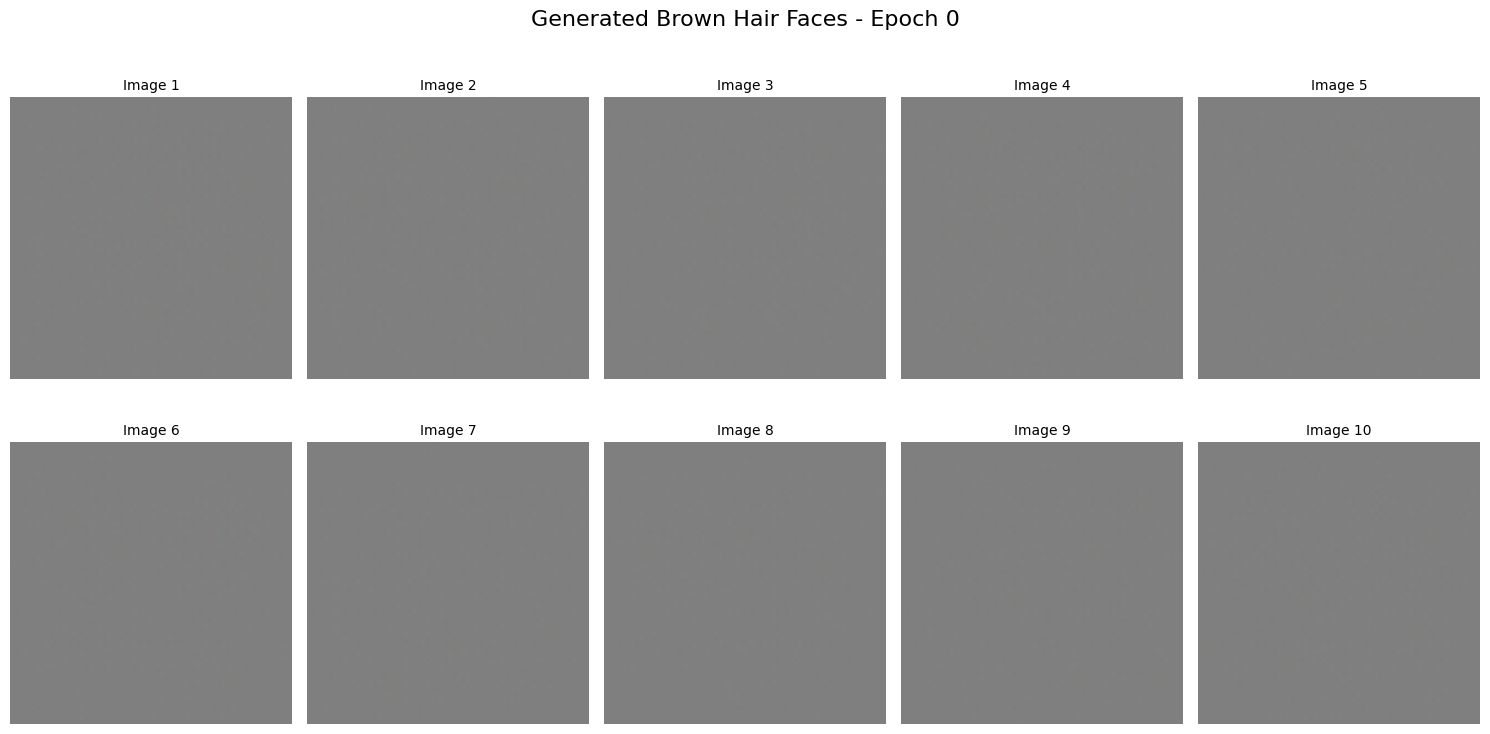

Generating non-brown hair faces for comparison:


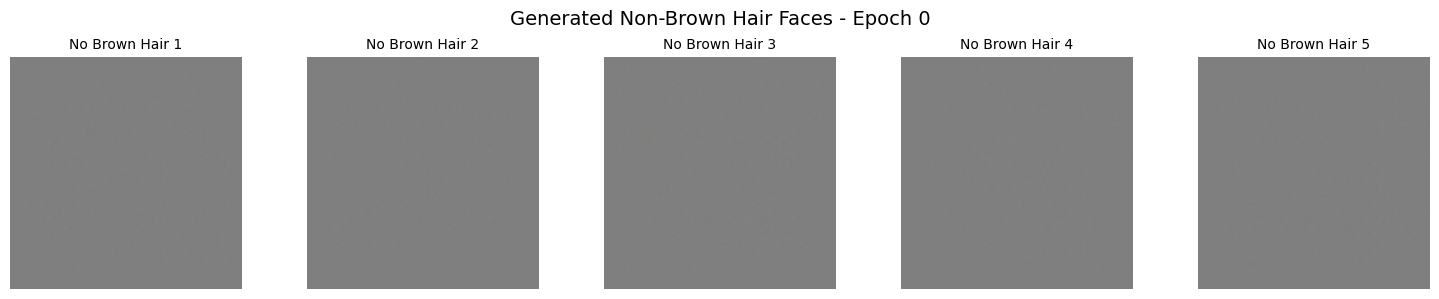

Epoch 1/100: 100%|██████████| 157/157 [05:01<00:00,  1.92s/it, D_loss=0.5535, G_loss=4.9934]


Epoch [1/100] - D_loss: 0.8927, G_loss: 8.9375

Generated images at epoch 1:
Generated image range: [-1.000, 0.992]


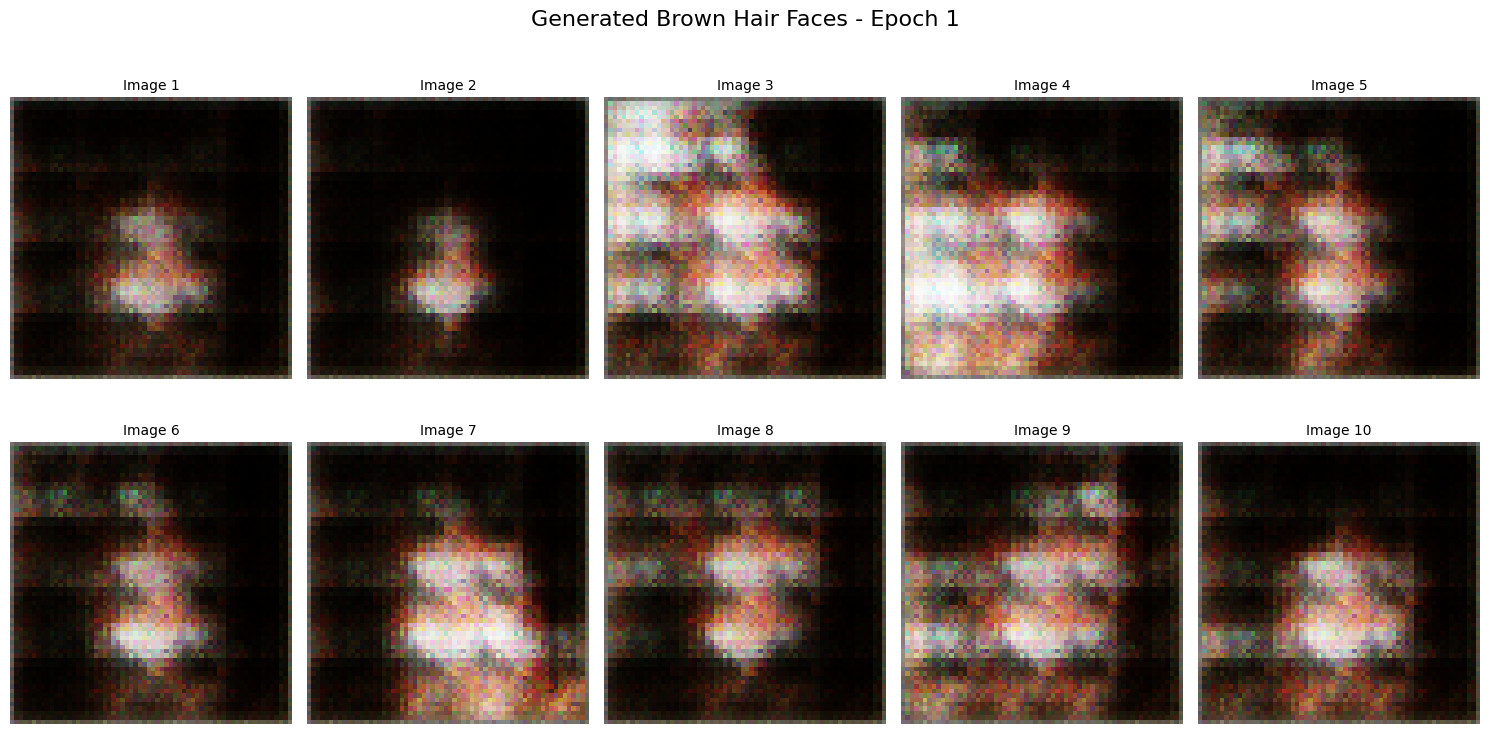

Generating non-brown hair faces for comparison:


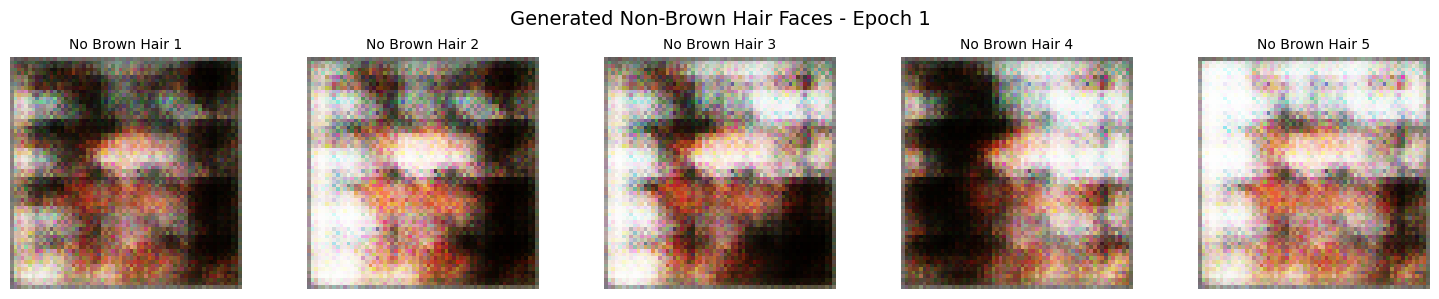

Epoch 2/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.7092, G_loss=3.6228]


Epoch [2/100] - D_loss: 0.7481, G_loss: 4.4140


Epoch 3/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.9428, G_loss=2.4553]


Epoch [3/100] - D_loss: 1.0504, G_loss: 3.0281


Epoch 4/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=1.0482, G_loss=4.1535]


Epoch [4/100] - D_loss: 1.0084, G_loss: 3.0380


Epoch 5/100: 100%|██████████| 157/157 [02:07<00:00,  1.23it/s, D_loss=0.9956, G_loss=2.3407]


Epoch [5/100] - D_loss: 1.0103, G_loss: 3.1713

Generated images at epoch 5:
Generated image range: [-1.000, 1.000]


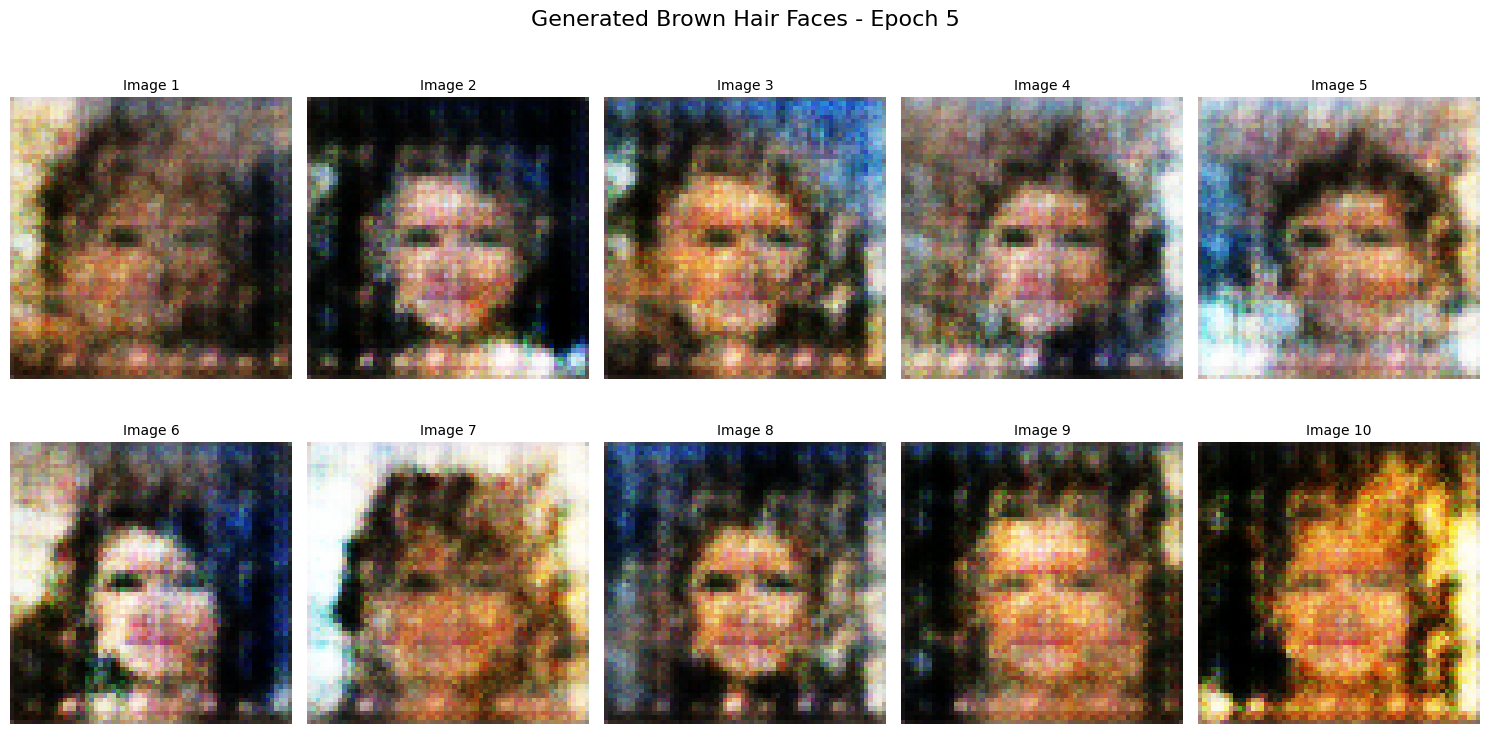

Generating non-brown hair faces for comparison:


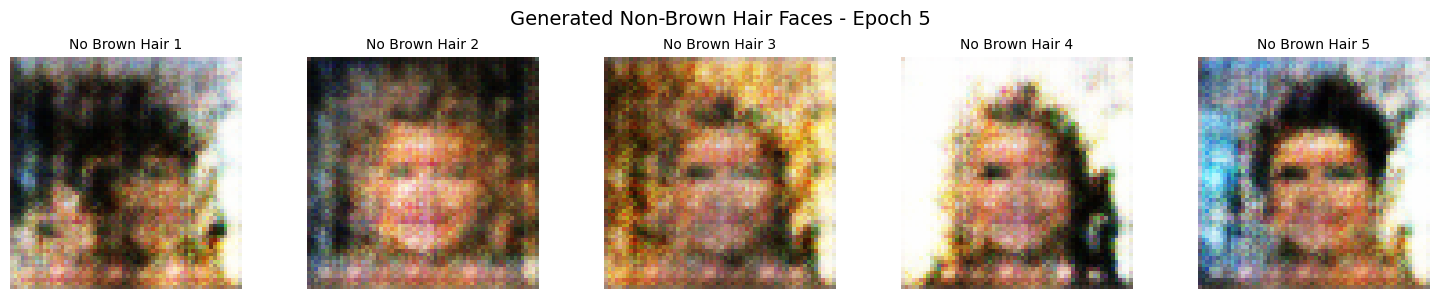

Epoch 6/100: 100%|██████████| 157/157 [01:56<00:00,  1.35it/s, D_loss=1.0731, G_loss=3.8968]


Epoch [6/100] - D_loss: 1.0316, G_loss: 3.2289


Epoch 7/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.7981, G_loss=3.4645]


Epoch [7/100] - D_loss: 1.0720, G_loss: 2.9951


Epoch 8/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=1.7261, G_loss=5.0277]


Epoch [8/100] - D_loss: 0.9993, G_loss: 2.9996


Epoch 9/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.9720, G_loss=2.0250]


Epoch [9/100] - D_loss: 0.9498, G_loss: 3.0889


Epoch 10/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.6977, G_loss=2.8486]


Epoch [10/100] - D_loss: 0.8919, G_loss: 3.0415

Generated images at epoch 10:
Generated image range: [-1.000, 1.000]


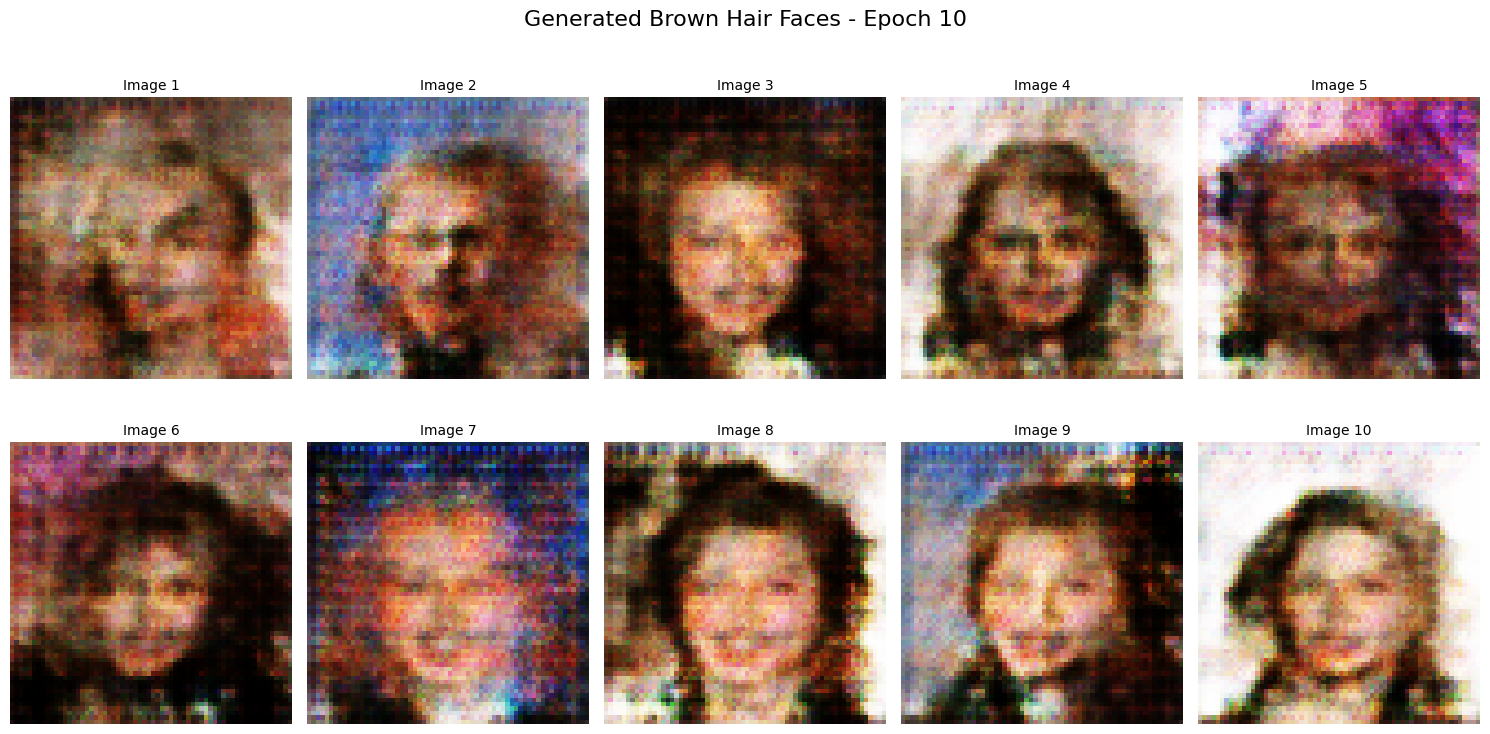

Generating non-brown hair faces for comparison:


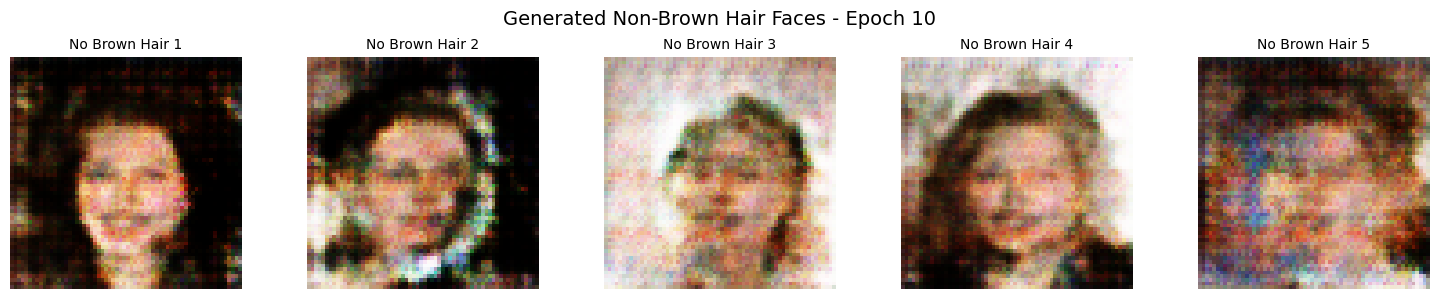

Epoch 11/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.7783, G_loss=4.1726]


Epoch [11/100] - D_loss: 0.9350, G_loss: 2.9876


Epoch 12/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.6538, G_loss=2.4484]


Epoch [12/100] - D_loss: 0.8216, G_loss: 2.9088


Epoch 13/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=1.0552, G_loss=4.2689]


Epoch [13/100] - D_loss: 0.8219, G_loss: 2.9319


Epoch 14/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.8620, G_loss=1.3540]


Epoch [14/100] - D_loss: 0.8071, G_loss: 2.7270


Epoch 15/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=3.3109, G_loss=2.5488]


Epoch [15/100] - D_loss: 0.7915, G_loss: 2.6309

Generated images at epoch 15:
Generated image range: [-1.000, 1.000]


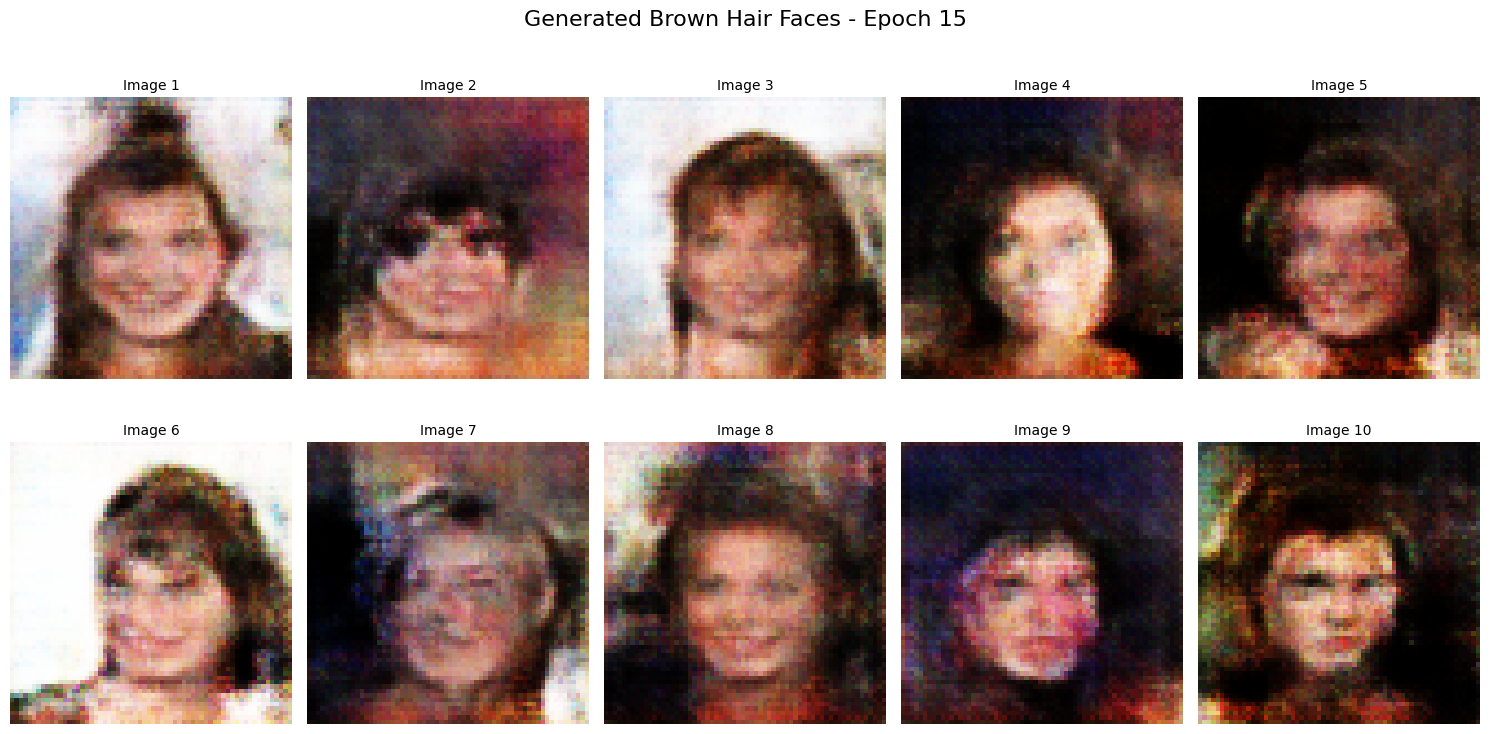

Generating non-brown hair faces for comparison:


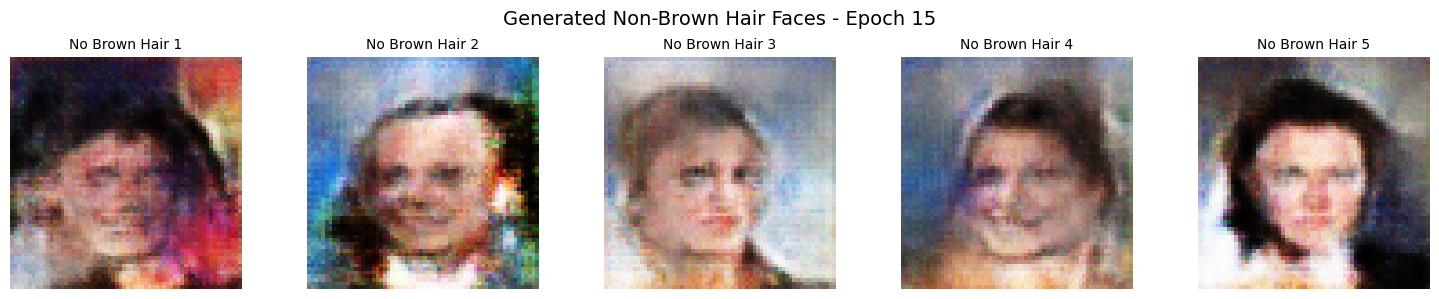

Epoch 16/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.8187, G_loss=3.5041]


Epoch [16/100] - D_loss: 0.7758, G_loss: 2.7007


Epoch 17/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.7044, G_loss=1.8290]


Epoch [17/100] - D_loss: 0.7683, G_loss: 2.7399


Epoch 18/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.5667, G_loss=3.1858]


Epoch [18/100] - D_loss: 0.7814, G_loss: 2.7519


Epoch 19/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=1.0287, G_loss=1.4585]


Epoch [19/100] - D_loss: 0.7487, G_loss: 2.7272


Epoch 20/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.6419, G_loss=2.3272]


Epoch [20/100] - D_loss: 0.7832, G_loss: 2.7611

Generated images at epoch 20:
Generated image range: [-1.000, 0.999]


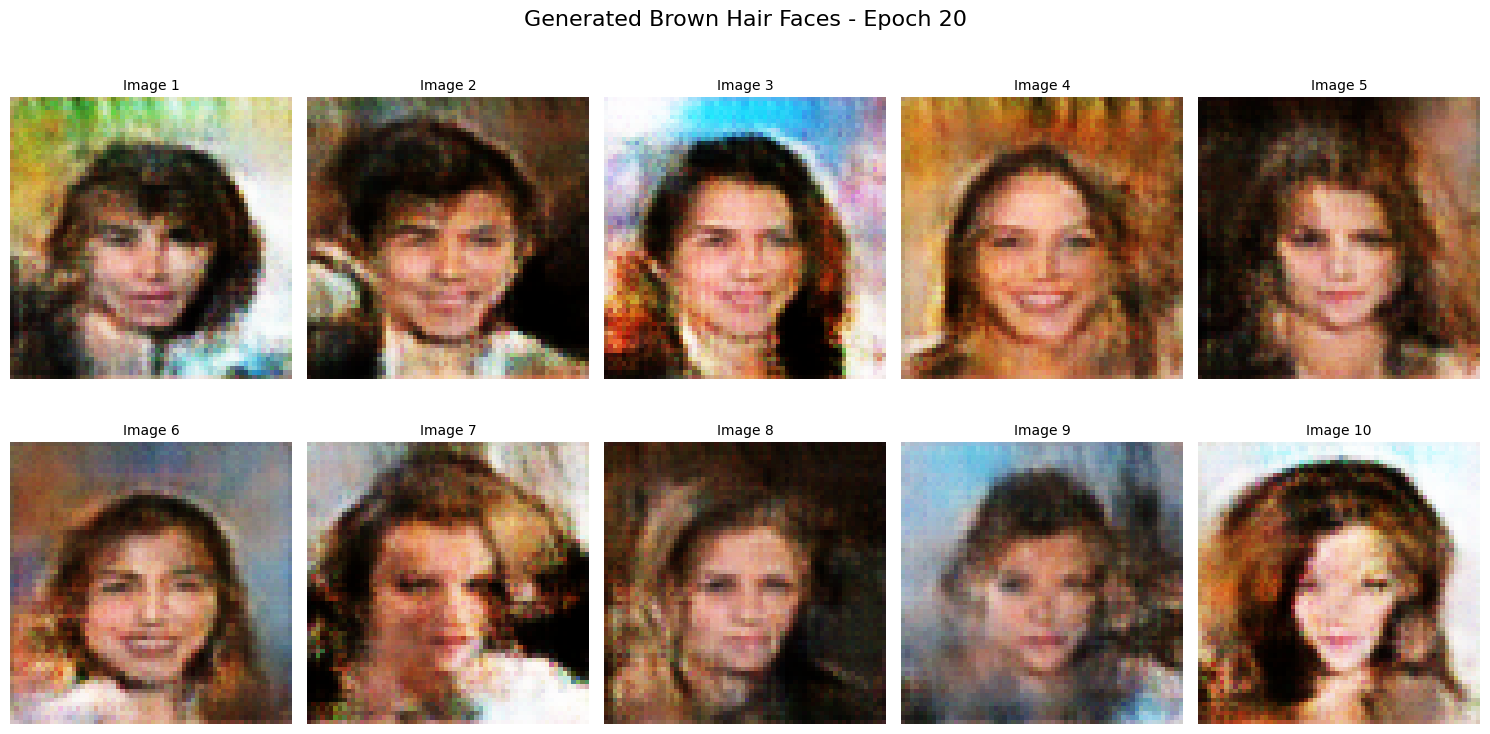

Generating non-brown hair faces for comparison:


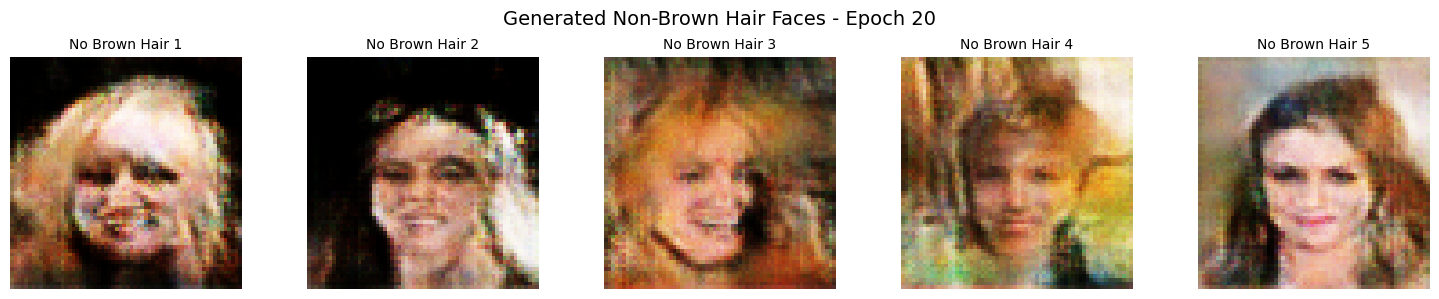

Epoch 21/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.6457, G_loss=3.8936]


Epoch [21/100] - D_loss: 0.7779, G_loss: 2.6354


Epoch 22/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=1.3473, G_loss=1.4109]


Epoch [22/100] - D_loss: 0.8022, G_loss: 2.6040


Epoch 23/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.6580, G_loss=1.8108]


Epoch [23/100] - D_loss: 0.7556, G_loss: 2.6105


Epoch 24/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.7108, G_loss=1.7710]


Epoch [24/100] - D_loss: 0.8018, G_loss: 2.6674


Epoch 25/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.5877, G_loss=2.5153]


Epoch [25/100] - D_loss: 0.7432, G_loss: 2.6058

Generated images at epoch 25:
Generated image range: [-1.000, 1.000]


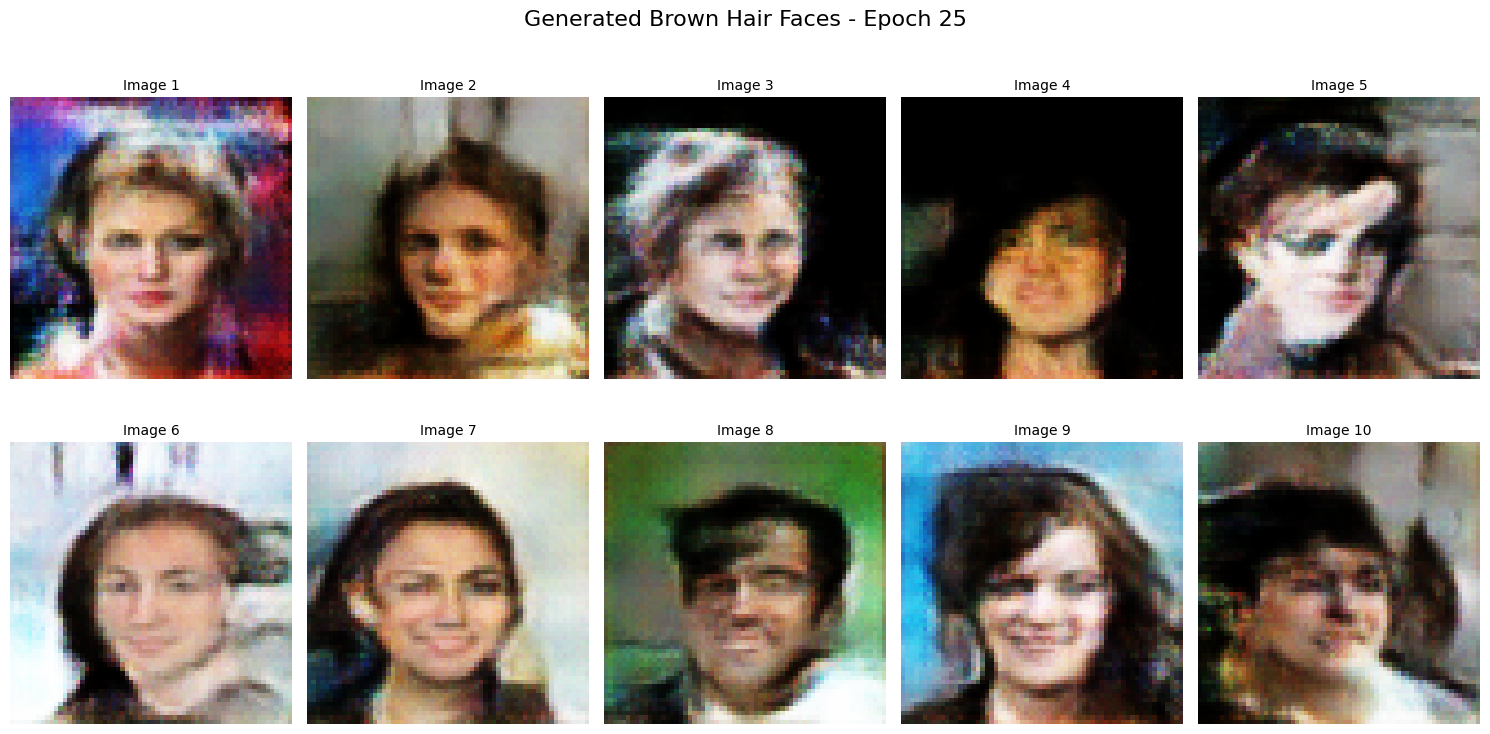

Generating non-brown hair faces for comparison:


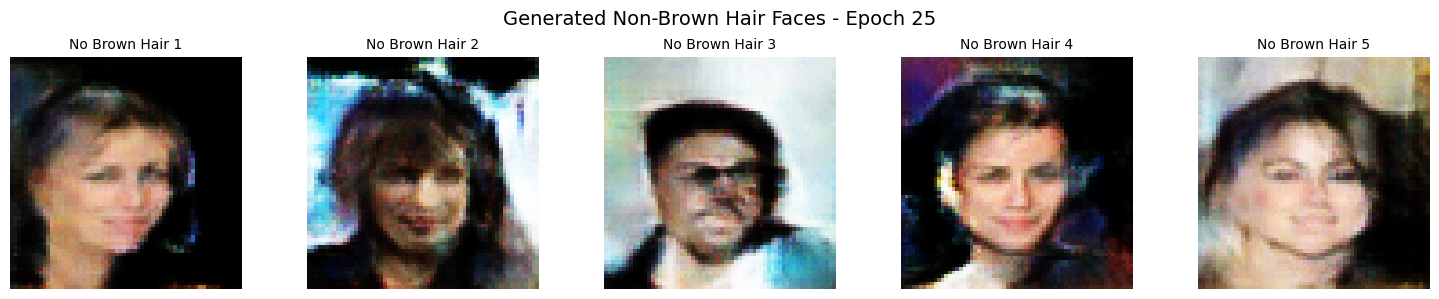

Epoch 26/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.5500, G_loss=2.7653]


Epoch [26/100] - D_loss: 0.7661, G_loss: 2.5517


Epoch 27/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.6637, G_loss=1.8723]


Epoch [27/100] - D_loss: 0.7623, G_loss: 2.6133


Epoch 28/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.7716, G_loss=1.7761]


Epoch [28/100] - D_loss: 0.7880, G_loss: 2.5673


Epoch 29/100: 100%|██████████| 157/157 [01:09<00:00,  2.25it/s, D_loss=0.6766, G_loss=3.6916]


Epoch [29/100] - D_loss: 0.6671, G_loss: 2.5862


Epoch 30/100: 100%|██████████| 157/157 [01:09<00:00,  2.25it/s, D_loss=0.6709, G_loss=4.3042]


Epoch [30/100] - D_loss: 0.7848, G_loss: 2.6389


Epoch 31/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.6373, G_loss=1.5868]


Epoch [31/100] - D_loss: 0.6974, G_loss: 2.6124


Epoch 32/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.4984, G_loss=3.2614]


Epoch [32/100] - D_loss: 0.7126, G_loss: 2.6815


Epoch 33/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.5352, G_loss=2.1732]


Epoch [33/100] - D_loss: 0.7318, G_loss: 2.7021


Epoch 34/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.5970, G_loss=2.3451]


Epoch [34/100] - D_loss: 0.7174, G_loss: 2.6892


Epoch 35/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.7860, G_loss=1.7022]


Epoch [35/100] - D_loss: 0.7000, G_loss: 2.6766


Epoch 36/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.6091, G_loss=2.8349]


Epoch [36/100] - D_loss: 0.6740, G_loss: 2.7460


Epoch 37/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.5191, G_loss=3.1416]


Epoch [37/100] - D_loss: 0.6273, G_loss: 2.7428


Epoch 38/100: 100%|██████████| 157/157 [01:09<00:00,  2.25it/s, D_loss=0.5077, G_loss=3.1220]


Epoch [38/100] - D_loss: 0.6870, G_loss: 2.7386


Epoch 39/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.9118, G_loss=1.4634]


Epoch [39/100] - D_loss: 0.6574, G_loss: 2.7910


Epoch 40/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.7724, G_loss=2.1366]


Epoch [40/100] - D_loss: 0.5888, G_loss: 2.8189


Epoch 41/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.8554, G_loss=3.4697]


Epoch [41/100] - D_loss: 0.6689, G_loss: 2.8358


Epoch 42/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.3960, G_loss=2.7251]


Epoch [42/100] - D_loss: 0.5554, G_loss: 2.7779


Epoch 43/100: 100%|██████████| 157/157 [01:09<00:00,  2.24it/s, D_loss=0.4060, G_loss=2.3652]


Epoch [43/100] - D_loss: 0.6303, G_loss: 2.9615


Epoch 44/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.4550, G_loss=2.0345]


Epoch [44/100] - D_loss: 0.5672, G_loss: 2.8262


Epoch 45/100: 100%|██████████| 157/157 [01:09<00:00,  2.25it/s, D_loss=0.3834, G_loss=3.2088]


Epoch [45/100] - D_loss: 0.6598, G_loss: 2.9237


Epoch 46/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.8668, G_loss=5.4748]


Epoch [46/100] - D_loss: 0.6659, G_loss: 2.9779


Epoch 47/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.4056, G_loss=2.1104]


Epoch [47/100] - D_loss: 0.4650, G_loss: 2.8351


Epoch 48/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.4121, G_loss=2.1114]


Epoch [48/100] - D_loss: 0.7279, G_loss: 2.9662


Epoch 49/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.5633, G_loss=2.0649]


Epoch [49/100] - D_loss: 0.5651, G_loss: 2.9257


Epoch 50/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.3011, G_loss=2.9394]


Epoch [50/100] - D_loss: 0.4399, G_loss: 2.9928


Epoch 51/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.3429, G_loss=3.2145]


Epoch [51/100] - D_loss: 0.5416, G_loss: 3.1817


Epoch 52/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.7586, G_loss=2.5460]


Epoch [52/100] - D_loss: 0.5627, G_loss: 3.1350


Epoch 53/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.5433, G_loss=1.9190]


Epoch [53/100] - D_loss: 0.4069, G_loss: 3.0392


Epoch 54/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.7506, G_loss=4.8202]


Epoch [54/100] - D_loss: 0.4310, G_loss: 3.2512


Epoch 55/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.3783, G_loss=4.2410]


Epoch [55/100] - D_loss: 0.5418, G_loss: 3.2004


Epoch 56/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.2275, G_loss=3.1936]


Epoch [56/100] - D_loss: 0.5614, G_loss: 3.1804


Epoch 57/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.2337, G_loss=3.9120]


Epoch [57/100] - D_loss: 0.5053, G_loss: 3.1640


Epoch 58/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=1.0432, G_loss=2.1953]


Epoch [58/100] - D_loss: 0.6103, G_loss: 3.2021


Epoch 59/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.4633, G_loss=1.7997]


Epoch [59/100] - D_loss: 0.4176, G_loss: 3.2043


Epoch 60/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.8365, G_loss=5.3983]


Epoch [60/100] - D_loss: 0.5982, G_loss: 3.3161


Epoch 61/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.2565, G_loss=3.2423]


Epoch [61/100] - D_loss: 0.3447, G_loss: 3.1671


Epoch 62/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.3106, G_loss=3.7780]


Epoch [62/100] - D_loss: 0.5215, G_loss: 3.3838


Epoch 63/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.2163, G_loss=3.8646]


Epoch [63/100] - D_loss: 0.2611, G_loss: 3.2510


Epoch 64/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.3586, G_loss=3.6977]


Epoch [64/100] - D_loss: 0.6528, G_loss: 3.4837


Epoch 65/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.2704, G_loss=3.3212]


Epoch [65/100] - D_loss: 0.3882, G_loss: 3.3121


Epoch 66/100: 100%|██████████| 157/157 [01:09<00:00,  2.28it/s, D_loss=2.3354, G_loss=5.7271]


Epoch [66/100] - D_loss: 0.4162, G_loss: 3.3860


Epoch 67/100: 100%|██████████| 157/157 [01:08<00:00,  2.28it/s, D_loss=0.3924, G_loss=2.6039]


Epoch [67/100] - D_loss: 0.4281, G_loss: 3.4567


Epoch 68/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.5772, G_loss=6.6741]


Epoch [68/100] - D_loss: 0.3429, G_loss: 3.5188


Epoch 69/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.2654, G_loss=2.8017]


Epoch [69/100] - D_loss: 0.5200, G_loss: 3.3944


Epoch 70/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.2692, G_loss=3.5692]


Epoch [70/100] - D_loss: 0.2702, G_loss: 3.4453


Epoch 71/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.2146, G_loss=3.7687]


Epoch [71/100] - D_loss: 0.4201, G_loss: 3.6554


Epoch 72/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=1.5682, G_loss=0.9607]


Epoch [72/100] - D_loss: 0.4880, G_loss: 3.6874


Epoch 73/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.4849, G_loss=5.2448]


Epoch [73/100] - D_loss: 0.3360, G_loss: 3.4899


Epoch 74/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=2.2110, G_loss=1.2211]


Epoch [74/100] - D_loss: 0.5199, G_loss: 3.6057


Epoch 75/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.2954, G_loss=2.4455]


Epoch [75/100] - D_loss: 0.3645, G_loss: 3.4265


Epoch 76/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.1372, G_loss=4.1604]


Epoch [76/100] - D_loss: 0.1950, G_loss: 3.5771


Epoch 77/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.2940, G_loss=3.2002]


Epoch [77/100] - D_loss: 0.6289, G_loss: 3.7096


Epoch 78/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.4734, G_loss=4.9373]


Epoch [78/100] - D_loss: 0.2891, G_loss: 3.5705


Epoch 79/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.1728, G_loss=3.9756]


Epoch [79/100] - D_loss: 0.1909, G_loss: 3.6450


Epoch 80/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.4282, G_loss=5.0912]


Epoch [80/100] - D_loss: 0.6246, G_loss: 3.6781


Epoch 81/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.1826, G_loss=3.7497]


Epoch [81/100] - D_loss: 0.1913, G_loss: 3.6624


Epoch 82/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.6946, G_loss=3.7022]


Epoch [82/100] - D_loss: 0.5507, G_loss: 3.8090


Epoch 83/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.6595, G_loss=1.2172]


Epoch [83/100] - D_loss: 0.3483, G_loss: 3.7030


Epoch 84/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.2480, G_loss=2.5377]


Epoch [84/100] - D_loss: 0.1988, G_loss: 3.7591


Epoch 85/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.1714, G_loss=4.8058]


Epoch [85/100] - D_loss: 0.1533, G_loss: 3.8822


Epoch 86/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.2699, G_loss=3.2376]


Epoch [86/100] - D_loss: 0.7474, G_loss: 3.8753


Epoch 87/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.1197, G_loss=4.1735]


Epoch [87/100] - D_loss: 0.1783, G_loss: 3.7453


Epoch 88/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.2563, G_loss=3.2326]


Epoch [88/100] - D_loss: 0.4768, G_loss: 3.9100


Epoch 89/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.2096, G_loss=3.7804]


Epoch [89/100] - D_loss: 0.1980, G_loss: 3.8197


Epoch 90/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.2021, G_loss=4.3899]


Epoch [90/100] - D_loss: 0.4517, G_loss: 3.8861


Epoch 91/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.1261, G_loss=4.5879]


Epoch [91/100] - D_loss: 0.1622, G_loss: 3.8483


Epoch 92/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.8304, G_loss=1.7529]


Epoch [92/100] - D_loss: 0.4973, G_loss: 4.0141


Epoch 93/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.2365, G_loss=4.5180]


Epoch [93/100] - D_loss: 0.2522, G_loss: 3.9135


Epoch 94/100: 100%|██████████| 157/157 [01:09<00:00,  2.27it/s, D_loss=0.1496, G_loss=3.9308]


Epoch [94/100] - D_loss: 0.2538, G_loss: 3.9911


Epoch 95/100: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s, D_loss=0.1238, G_loss=4.1979]


Epoch [95/100] - D_loss: 0.1317, G_loss: 4.0893


Epoch 96/100: 100%|██████████| 157/157 [02:28<00:00,  1.05it/s, D_loss=0.2711, G_loss=4.7967]


Epoch [96/100] - D_loss: 0.6438, G_loss: 3.9895


Epoch 97/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.0885, G_loss=4.5866]


Epoch [97/100] - D_loss: 0.1407, G_loss: 3.9779


Epoch 98/100: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s, D_loss=0.2193, G_loss=5.5916]


Epoch [98/100] - D_loss: 0.1237, G_loss: 4.1289


Epoch 99/100: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it, D_loss=0.1964, G_loss=3.7099]


Epoch [99/100] - D_loss: 0.5813, G_loss: 4.1150


Epoch 100/100: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s, D_loss=0.1432, G_loss=3.9159]

Epoch [100/100] - D_loss: 0.1663, G_loss: 4.0788


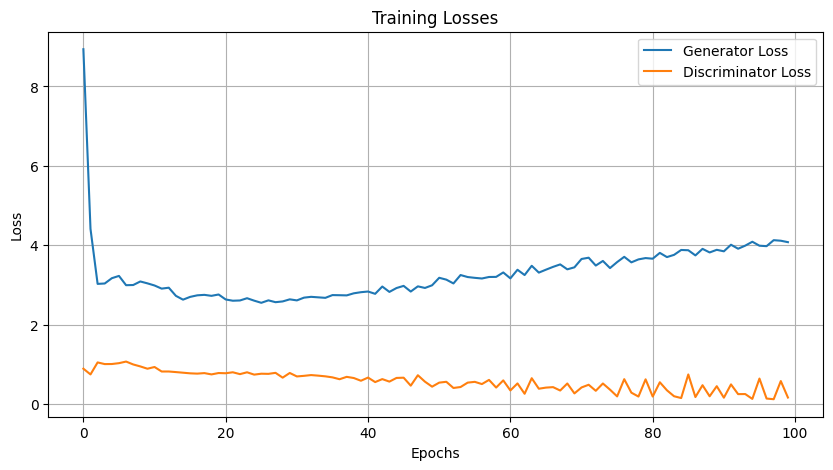

Training completed!

Final generated brown hair faces:
Generated image range: [-1.000, 0.998]


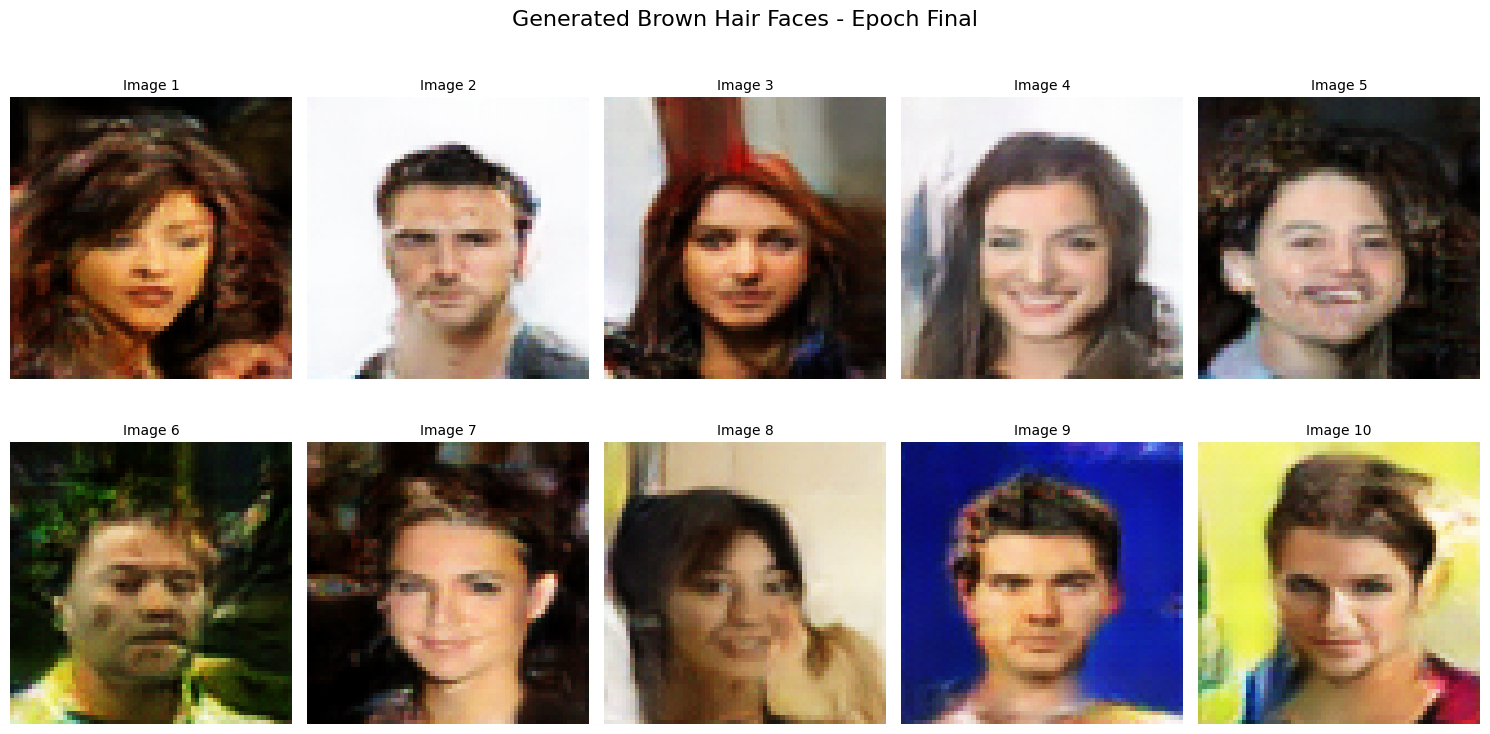

Generating non-brown hair faces for comparison:


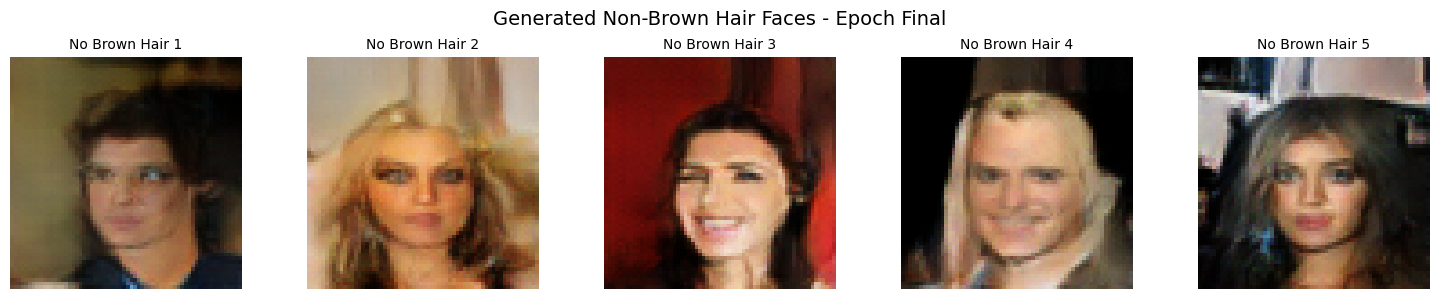

In [14]:
# Start training
if __name__ == "__main__":
    generator, discriminator = train_cgan()
    
    # Final generation with trained model
    print("\nFinal generated brown hair faces:")
    show_generated_images(generator, "Final", device, nz)